In [2]:
import random
import numpy  as np

In [3]:
""" # generate a random matrix

# 设置种子
np.random.seed(10)
# 生成矩阵
mt1 = np.random.randint(0, 100, size=250)

def extract_basics_split(data):
    means = np.empty((1, 50))
    stds = np.empty((1, 50))
    maxs = np.empty((1, 50))
    mins = np.empty((1, 50))
    medians = np.empty((1, 50))

    splits = np.array_split(data, 50)
    
    for j in range(len(splits)):
        means[0, j] = np.mean(splits[j])
        stds[0, j] = np.std(splits[j])
        maxs[0, j] = np.max(splits[j])
        mins[0, j] = np.min(splits[j])
        medians[0, j] = np.median(splits[j])

    features = np.array([means, stds, maxs, mins, medians])

    features = features.T
    return features

features = extract_basics_split(mt1)
print(features) """

' # generate a random matrix\n\n# 设置种子\nnp.random.seed(10)\n# 生成矩阵\nmt1 = np.random.randint(0, 100, size=250)\n\ndef extract_basics_split(data):\n    means = np.empty((1, 50))\n    stds = np.empty((1, 50))\n    maxs = np.empty((1, 50))\n    mins = np.empty((1, 50))\n    medians = np.empty((1, 50))\n\n    splits = np.array_split(data, 50)\n    \n    for j in range(len(splits)):\n        means[0, j] = np.mean(splits[j])\n        stds[0, j] = np.std(splits[j])\n        maxs[0, j] = np.max(splits[j])\n        mins[0, j] = np.min(splits[j])\n        medians[0, j] = np.median(splits[j])\n\n    features = np.array([means, stds, maxs, mins, medians])\n\n    features = features.T\n    return features\n\nfeatures = extract_basics_split(mt1)\nprint(features) '

# Load in the data

In [4]:
#Import libaries
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft
from scipy.io import wavfile 
from scipy.signal import filtfilt, butter
from pylab import *
import os
import librosa

#Import self-written functions
from Denoise_Functions import *
from features_functions import *

#Get directories with data
dir_gearbox = os.path.join(os.getcwd(), 'gearbox')
dir_train = os.path.join(dir_gearbox, "train")
dir_test = os.path.join(dir_gearbox, "test")

# Extract anomoly files and normal files from the test set
anom_files = []
anom_sr = []
anom_data = []
anom_data_fft = []

norm_files = []
norm_sr = []
norm_data = []
norm_data_fft = []

# make a list of all the files in the training data folder that contain section_00 in the name and volt_1.0 in the name
for i in os.listdir(dir_test):
    if 'anomaly' in i and 'section_00' in i and 'volt_1.0' in i:
        anom_files.append(i)
        # data, samplerate = librosa.load(dir_test + '/' + i,sr=16000)
        samplerate, data = wavfile.read(dir_test + '\\' + i)
        anom_sr.append(samplerate)
        anom_data.append(data)

        #Also store the fft data
        data_fft_v1 = fft(data)
        data_fft = 2.0/(data.shape[0]) * np.abs(data_fft_v1[0:data.shape[0]//2])
        anom_data_fft.append(data_fft)

    if 'normal' in i and 'section_00' in i and 'volt_1.0' in i:
        norm_files.append(i)
        # data, samplerate = librosa.load(dir_test + '/' + i,sr=16000)
        samplerate, data = wavfile.read(dir_test + '\\' + i)
        norm_sr.append(samplerate)
        norm_data.append(data)

        #Also store the fft data
        data_fft_v1 = fft(data)
        data_fft = 2.0/(data.shape[0]) * np.abs(data_fft_v1[0:data.shape[0]//2])
        norm_data_fft.append(data_fft)

# extract basic features
anom_means, anom_stds, anom_maxs, anom_mins, anom_medians = extract_basics_split(anom_data)
norm_means, norm_stds, norm_maxs, norm_mins, norm_medians = extract_basics_split(norm_data)

# convert list objectives to numpy array form
anom_means_arr = np.array(anom_means)
anom_stds_arr = np.array(anom_stds)
anom_maxs_arr = np.array(anom_maxs)
anom_mins_arr = np.array(anom_mins)
anom_medians_arr = np.array(anom_medians)
norm_means_arr = np.array(norm_means)
norm_stds_arr = np.array(norm_stds)
norm_maxs_arr = np.array(norm_maxs)
norm_mins_arr = np.array(norm_mins)
norm_medians_arr = np.array(norm_medians)

""" # create a matrix of size n_samples times n_features
X_anom = np.stack([anom_means_arr, anom_stds_arr, anom_maxs_arr, anom_mins_arr, 
                         anom_medians_arr], axis=0).T

X_norm = np.stack([norm_means_arr, norm_stds_arr, norm_maxs_arr, 
                         norm_mins_arr, norm_medians_arr], axis=0).T """

# create a matrix of size n_samples times n_features
means_arr = np.append(anom_means_arr, norm_means_arr)
stds_arr = np.append(anom_stds_arr, norm_stds_arr)
maxs_arr = np.append(anom_maxs_arr, norm_maxs_arr)
mins_arr = np.append(anom_mins_arr, norm_mins_arr)
medians_arr = np.append(anom_medians_arr, norm_medians_arr)

features_high_dim = np.stack([means_arr, stds_arr, maxs_arr, mins_arr, 
                         medians_arr], axis=0).T


In [5]:
import random
import numpy  as np

# define the fitness function
def  calculate_fitness(individual , X):
    # Convert  binary  string  to  boolean  mask
    mask = np.array(list(individual), dtype=bool)
    # Apply  mask to  dataset
    X_masked = X[:, mask]
    # Calculate  variance  of each  feature
    variances = np.var(X_masked , axis =0)
    # Calculate  fitness  as the  sum of  variances
    fitness = np.sum(variances)
    
    return  fitness


# define the genetic algorithm
def genetic_algorithm(data, n_features, population_size, num_genes, calculate_fitness, mutation_rate, elitism_rate, num_generations):
    """ 
    Implement genetic algorithm which derives features of low dimentionality from feature of high dimensionality. (dimensionality of features reduction)

    Params:
    data: input data on which genetic algorithm will be implemented; size: n_samples * n_features (high dimension)
    n_features: target number of features (low dimension)
    population_size: population size initialization 
    num_genes: = n_features (high dimension)
    calculate_fitness: fitness score function
    mutation_rate: mutation rate, between (0, 1) 
    elitism_rate: elitism rate, between (0, 1)
    num_generations: number of generations
    

    return: features of low dimenstionatlity
    """
    # initialize the population
    population = []
    for i in range(population_size):
        individual = [0] * num_genes  # initialize all genes to zeros
        for j in random.sample(range(num_genes), n_features):  # choose genes locations randomly
            individual[j] = 1  # set the chosen genes locations to one
        population.append(individual)

    # run the evolution loop for num_generations
    for generation in range(num_generations):
        # evaluate the fitness of each individual in the population
        fitness_values = [calculate_fitness(individual, data) for individual in population]

        # select the fittest individuals for the next generation
        num_elites = int(elitism_rate * population_size)
        elites = sorted(range(len(population)), key=lambda i: fitness_values[i], reverse=True)[:num_elites]
        next_generation = [population[i] for i in elites]

        # breed new individuals to fill the rest of the next generation
        while len(next_generation) < population_size:
            """ parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
            child = []
            # to ensure number of genes chosen will not exceed n_features, we will select a crossover point, then copy the genes before the location from parent1, and copy the rest
            #of genes after the location from parent2
            crossover_point = random.randint(1, num_genes-1)   # choose a crossover point
            # perform crossover
            child = parent1[:crossover_point] + parent2[crossover_point:] """
            parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
            child = [parent1[i] if random.random() < 0.5 else parent2[i] for i in range(num_genes)]
            # if the number of genes chosen exceeds n_features, then we will randomly set genes to zero until the number is equal to n_features
            while sum(child) >= n_features:
                random_index = random.randint(0, len(child) - 1)
                child[random_index] = 0

            # in mutation operation, in order to ensure number of genes chosen will not exceed n_features, we will check if the number of genes chosen already equals to n_features,
            # if so, we will not proceed mutation operation. If not, we will continue to choose one genes to make negation
            if random.random() < mutation_rate:
                gene_to_mutate = random.randint(0, num_genes-1)
                if sum(child) < n_features:
                    child[gene_to_mutate] = 1 - child[gene_to_mutate]
            next_generation.append(child)
            

        # replace the old population with the new generation
        population = next_generation

    features_chosen = max(population, key=lambda individual: calculate_fitness(individual, data))
    # Convert  binary  string  to  boolean  mask
    features_mask= np.array(list(features_chosen), dtype=bool)
    # Apply  mask to  dataset
    features = data[:, features_mask]

    # return the features of low dimensionatlity
    return features





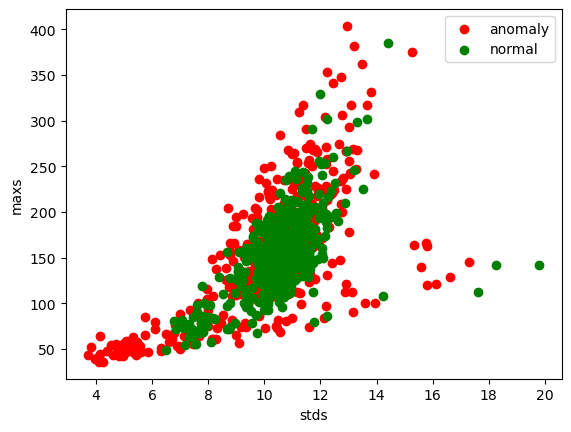

In [6]:
import numpy as np
import matplotlib.pyplot as plt

n_features =2
data = features_high_dim
population_size = 32   # 2 to the n_feature th
num_genes = 5
mutation_rate=0.01
elitism_rate=0.1
num_generations=10

features = genetic_algorithm(data, n_features, population_size, num_genes, calculate_fitness, mutation_rate=0.01, elitism_rate=0.1, num_generations=100)

# draw scatter plot with the features found
def features_plot(features, n_norm, n_anom):
    x_anom = features[:n_anom, 0]
    y_anom = features[:n_anom, 1]
    x_norm = features[n_anom:, 0]
    y_norm = features[n_anom:, 1]
    plt.scatter(x_anom, y_anom, c = 'red', label = 'anomaly')
    plt.scatter(x_norm, y_norm, c = 'green', label = 'normal')

    plt.legend()
    plt.xlabel('stds')
    plt.ylabel('maxs')
    plt.show()


features_plot(features, n_norm = 500, n_anom = 500)

In [7]:
""" while len(next_generation) < population_size:
    parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
    child = []
    while len(child) < 3:
        gene = random.choice(parent1) if random.random() < 0.5 else random.choice(parent2)
        if gene not in child:
            child.append(gene)
    child = [1 if gene in child else 0 for gene in parent1]   # assume parent1 and parent2 have same genes
    if random.random() < mutation_rate:
        gene_to_mutate = random.randint(0, num_genes-1)
        child[gene_to_mutate] = 1 - child[gene_to_mutate]
    next_generation.append(child)
 """

' while len(next_generation) < population_size:\n    parent1, parent2 = random.choices(population, weights=fitness_values, k=2)\n    child = []\n    while len(child) < 3:\n        gene = random.choice(parent1) if random.random() < 0.5 else random.choice(parent2)\n        if gene not in child:\n            child.append(gene)\n    child = [1 if gene in child else 0 for gene in parent1]   # assume parent1 and parent2 have same genes\n    if random.random() < mutation_rate:\n        gene_to_mutate = random.randint(0, num_genes-1)\n        child[gene_to_mutate] = 1 - child[gene_to_mutate]\n    next_generation.append(child)\n '

In [8]:
""" def genetic_algorithm(data, population_size, num_genes, calculate_fitness, mutation_rate, elitism_rate, num_generations):
    # initialize the population
    population = []
    for i in range(population_size):
        individual = [random.randint(0, 1) for j in range(num_genes)]   #######
        population.append(individual)
        # print(population)

    # run the evolution loop for num_generations
    for generation in range(num_generations):
        # evaluate the fitness of each individual in the population
        fitness_values = [calculate_fitness(individual, data) for individual in population]

        # select the fittest individuals for the next generation
        num_elites = int(elitism_rate * population_size)
        elites = sorted(range(len(population)), key=lambda i: fitness_values[i], reverse=True)[:num_elites]
        next_generation = [population[i] for i in elites]

        # breed new individuals to fill the rest of the next generation
        while len(next_generation) < population_size:
            parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
            child = [parent1[i] if random.random() < 0.5 else parent2[i] for i in range(num_genes)]   #########
            if random.random() < mutation_rate:
                gene_to_mutate = random.randint(0, num_genes-1)
                child[gene_to_mutate] = 1 - child[gene_to_mutate]
            next_generation.append(child)

        # replace the old population with the new generation
        population = next_generation
        # print(population)

    # return the fittest individual found
    return max(population, key=lambda individual: calculate_fitness(individual, data)) """

' def genetic_algorithm(data, population_size, num_genes, calculate_fitness, mutation_rate, elitism_rate, num_generations):\n    # initialize the population\n    population = []\n    for i in range(population_size):\n        individual = [random.randint(0, 1) for j in range(num_genes)]   #######\n        population.append(individual)\n        # print(population)\n\n    # run the evolution loop for num_generations\n    for generation in range(num_generations):\n        # evaluate the fitness of each individual in the population\n        fitness_values = [calculate_fitness(individual, data) for individual in population]\n\n        # select the fittest individuals for the next generation\n        num_elites = int(elitism_rate * population_size)\n        elites = sorted(range(len(population)), key=lambda i: fitness_values[i], reverse=True)[:num_elites]\n        next_generation = [population[i] for i in elites]\n\n        # breed new individuals to fill the rest of the next generation\n    